In [50]:
# === Imports de base ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import polars as pl

# === Machine learning ===
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA


import plotly.express as px

In [51]:
df_total = pl.read_parquet("../data/processed/total.parquet")
df_interaction = pl.read_parquet("../data/processed/total.parquet")

In [52]:
df_user = (
    df_total.with_columns(
        tags_clean=(
            pl.col("tags")
            .str.replace_all(r"[\[\]']", "")  # remove brackets & quotes
            .str.replace_all(r"^\s+|\s+$", "")  # remove leading/trailing spaces
            .str.split(",")  # split on comma + optional spaces
        )
    )
    .group_by("user_id")
    .agg(
        nb_reviews=pl.len(),
        mean_rating=pl.col("rating").mean(),
        std_rating=pl.col("rating").std(),
        mean_steps=pl.col("n_steps").mean(),
        review_length=pl.col("review").flatten().str.split(" ").list.len().mean(),
        mean_time=pl.col("minutes").mean(),
        nb_ingredients=pl.col("n_ingredients").mean(),
    )
)

df_user = df_user.with_columns(
    pl.col("std_rating").fill_nan(0).fill_null(0).alias("std_rating")
)


# df_user = df_user.with_columns(
#    pl.col("nb_reviews").log1p().alias("nb_reviews")
# )

In [54]:
features = ["nb_reviews", "mean_rating", "std_rating", "review_length", "mean_time"]
df_user = df_user.drop_nulls()
pd_user = df_user[features].to_pandas()
scaler = StandardScaler()
pd_user_scaled = scaler.fit_transform(pd_user)

In [58]:
inertia = []
for i in range(15):
    kmeans = KMeans(n_clusters=n_cluster, random_state=42, n_init=10)
    kmeans.fit(pd_user_scaled)
    inertia.append(kmeans.inertia_)


fig = px.line(
    x=range(15),
    y=inertia,
    title="Elbow method for best number of cluster",
)
fig.show()

In [76]:
n_cluster = 7
kmeans = KMeans(n_clusters=n_cluster, random_state=42, n_init=10)
cluster = kmeans.fit_predict(pd_user_scaled)
pd_user["cluster"] = cluster
df_user = df_user.with_columns(pl.Series("cluster", cluster))

In [77]:
df_interaction_cluster = df_interaction.join(
    df_user.select(["user_id", "cluster"]),
    on="user_id",
    how="left",  # keep all interactions; add cluster where user_id matches
)

In [ ]:
fig = px.histogram(
    pd_user,  # convert from Polars
    x="cluster",
    nbins=n_cluster,  # one bin per cluster
    title="Nombre d’utilisateurs par cluster",
    labels={"cluster": "Cluster", "count": "Nombre d’utilisateurs"},
)
fig.show()

In [62]:
pd_user.head()

,nb_reviews,mean_rating,std_rating,review_length,mean_time,cluster
0,1,5.0,0.000000,12.0,80.0,0
1,2,2.5,0.707107,90.5,45.0,1
2,1,5.0,0.000000,31.0,16.0,0
3,2,5.0,0.000000,60.5,48.5,1
4,1,5.0,0.000000,29.0,3.0,0


In [ ]:
fig = px.scatter(
    pd_user,
    x="nb_reviews",  # X-axis: number of reviews
    y="mean_rating",  # Z-axis: mean rating
    color="cluster",  # color by cluster
    opacity=0.7,
    title="nb_reviews vs mean_rating",
    labels={
        "nb_reviews": "Nombre de reviews",
        "mean_rating": "Note moyenne",
        "cluster": "Cluster",
    },
)


fig.update_traces(marker=dict(size=4))
fig.show()

In [ ]:
fig = px.scatter(
    pd_user,
    x="nb_reviews",  # X-axis: number of reviews
    y="review_length",  # Z-axis: mean rating
    color="cluster",  # color by cluster
    opacity=0.7,
    title="nb_reviews vs review_length",
    labels={
        "nb_reviews": "Nombre de reviews",
        "review_length": "Longueur moyenne des reviews",
        "cluster": "Cluster",
    },
)


fig.update_traces(marker=dict(size=4))
fig.show()

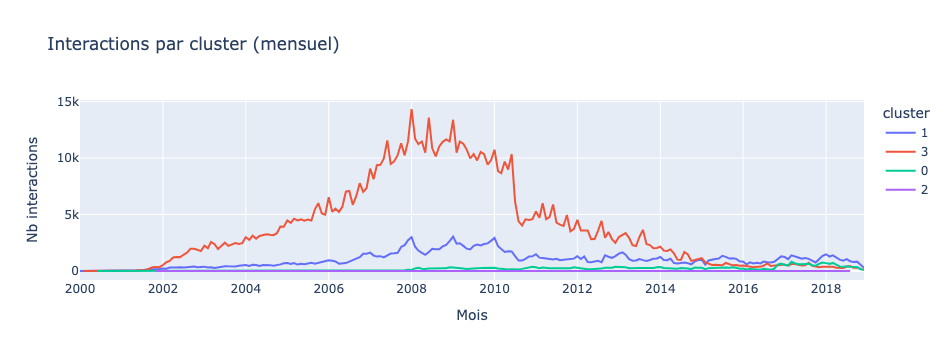

In [61]:
df_time = (
    df_interaction_cluster.with_columns(
        pl.col("date").dt.truncate("1mo").alias("month")
    )
    .group_by(["month", "cluster"])
    .agg(pl.len().alias("n_interactions"))
    .sort("month")
)

pdf = df_time.to_pandas()

fig = px.line(
    pdf,
    x="month",
    y="n_interactions",
    color="cluster",
    title="Interactions par cluster (mensuel)",
    labels={"month": "Mois", "n_interactions": "Nb interactions"},
)
fig.update_xaxes(type="date")
fig.show()